In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import tensorflow as tf

from sklearn import datasets

tf.__version__

'2.10.0'

[1 1 1 0 1]


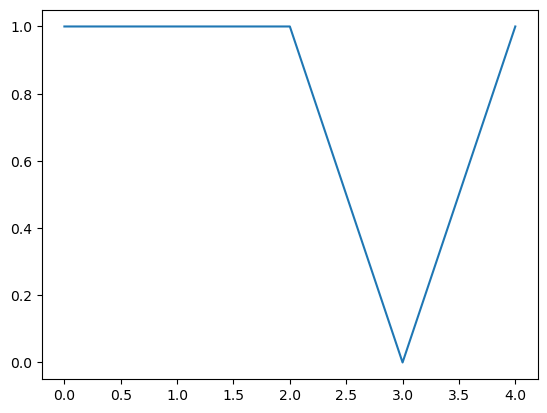

In [12]:
# 加载数据
train_datas = np.load("npy/train_datas.npy")
train_input_datas = np.load("npy/train_input_datas.npy")
test_datas = np.load("npy/test_datas.npy")
test_input_datas = np.load("npy/test_input_datas.npy")

print(train_input_datas[0,:5])
mpl.pyplot.plot(train_input_datas[0,:5])

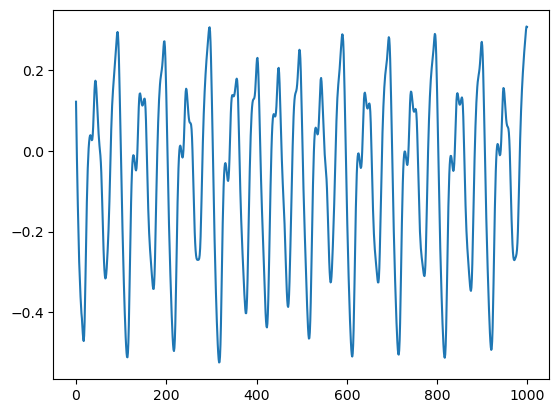

In [13]:
data = np.loadtxt('MackeyGlass_t17.txt')
mpl.pyplot.plot(data[:1000])

Computing spectral radius...
done.
MSE = 1.0234266166444487e-06


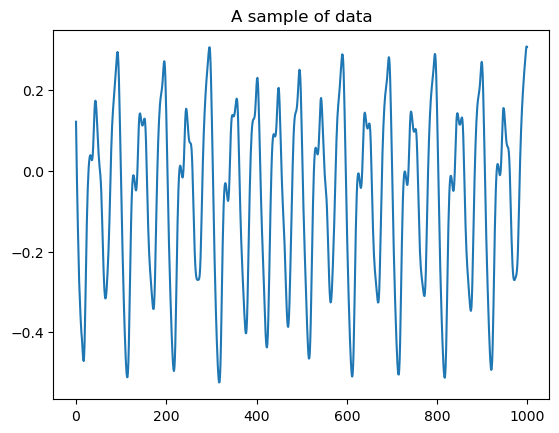

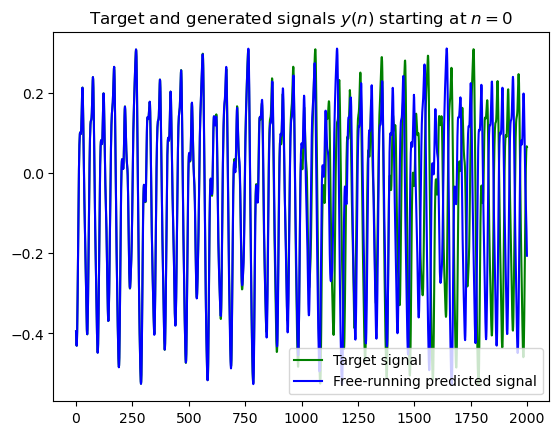

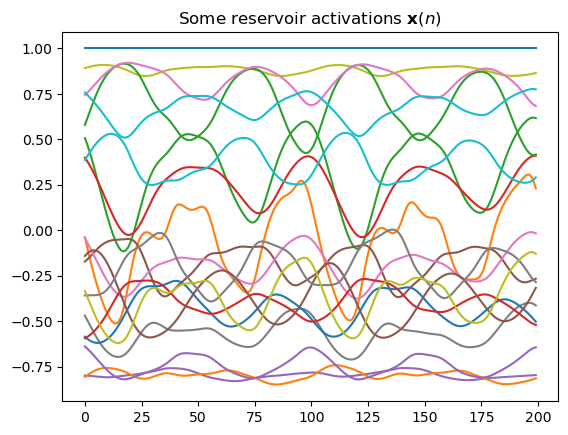

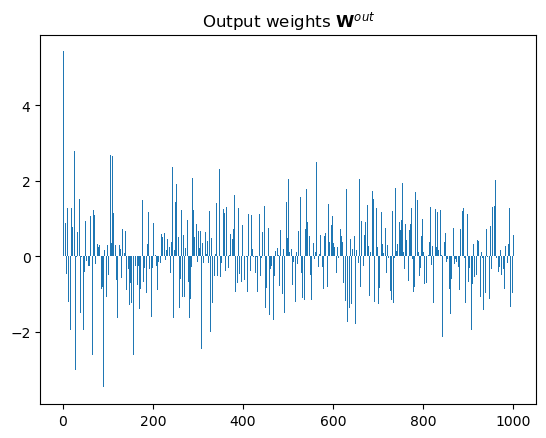

In [14]:
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
from https://mantas.info/code/simple_esn/
(c) 2012-2020 Mantas Luko拧evi膷ius
Distributed under MIT license https://opensource.org/licenses/MIT
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg 
# numpy.linalg is also an option for even fewer dependencies
# 线性代数算法，很多库都有提供，主要是用特征值计算和回归分析（这里用的岭回归）

# load the data
# 加载数据，划分训练集和测试集
trainLen = 2000
testLen = 2000
initLen = 100
# 输入数据data是一个10000个元素的行向量
data = np.loadtxt('MackeyGlass_t17.txt')

# plot some of it
# 预览一下数据集
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')

# generate the ESN reservoir
# 生成储备池
inSize = outSize = 1
resSize = 1000
a = 0.3 # leaking rate
        # 可以看作是储备池更新的速度，可不加，也就是设置成1
np.random.seed(42)  # 预测结果和这个随机种子关系很大（因为是伪随机数）
                    # 同一个种子做出来的存储池是完全一样的
Win = (np.random.rand(resSize,1+inSize) - 0.5) * 1  # 输入矩阵的尺寸为(1000,2)，之所以有个2因为多了一个偏置量basis
                                                    # Win本质上就是把1维输入向量（本例输入向量长度1，就一个元素）映射到了1000维的高维空间
W = np.random.rand(resSize,resSize) - 0.5 
# normalizing and setting spectral radius (correct, slow):
# 谱半径的理解：WX=AX，那么W/A_max *X <= X，确保了经过权重矩阵变换后的输入向量，取值区间不会膨胀得太离谱（这会极大影响分类器）
print('Computing spectral radius...')
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')
W *= 1.25 / rhoW

# allocated memory for the design (collected states) matrix
# 设置状态收集矩阵，形状为(1002,1900)，之所以颠倒行列，是为了岭回归时候，省一次转置
X = np.zeros((1+inSize+resSize,trainLen-initLen))   # 这里的1表达basis的个数
# set the corresponding target matrix directly
# 这其实是输出矩阵，每一列代表一个时刻的输出（可能是为了画图方便用的）
# 这里的第一个参数None其实是为了升维，把原本的行向量，变成了(1,1900)形状的矩阵Yt
# 【注意】这里有一个小玄机，因为是要构造预测问题，所以在构造数据集input->output映射的时候，做了一个错位，例第101行的数字作为输入u，对应的预期输出y是第102行的数字
# 【继续注意】在这种思想指导下，如果是101-110行数字连续十个样本同时作为第111行的数字的预测参考，那么基于马尔可夫的长期记忆效果就出现了
Yt = data[None,initLen+1:trainLen+1] 

# run the reservoir with the data and collect X
# 并不是训练了！用训练数据集运行储备池，并收集状态，仅仅是把所有数据在池子中计算了一次
x = np.zeros((resSize,1))   # 临时变量，代表储备池上一个时刻的状态
for t in range(trainLen):
    u = data[t] # 捕获第t个元素的数据（其实就是一个数字）（data是一个一万元素的行向量）
    
    # 这一行公式有点困惑？【答】a只是更新速度，没啥的
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) ) # tanh(x'_t)，其中x'_t是一个长度=1000的行向量，由过去时刻的x(t-1)通过一次内部神经元映射后加上新来的输入x(t)
                                        # 注意x是消极更新的，由变量a控制，也可以设置为1（积极更新）
                                        # vstack((1, u)其实是加了偏置量basis=1
                                        # vstack是沿着垂直方向拼接，也就是把行向量拼成矩阵
    if t >= initLen:    # 空转一百次后开始记录状态
        X[:,t-initLen] = np.vstack((1,u,x))[:,0]
        # 这边收集的(1,u,x)堆叠成的超大列向量才是esn储备池计算获得的结果
    
# train the output by ridge regression
# 用岭回归（所以说本质上还是一种统计学）来训练输出，简单来说就是用输入值和储备池状态去拟合目标值，改用别的线性回归模型甚至神经网络也可以，这里用的是岭回归
reg = 1e-8  # regularization coefficient
            # 正则化系数（岭回归用的）
# direct equations from texts:
#X_T = X.T
#Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
#    reg*np.eye(1+inSize+resSize) ) )
# using scipy.linalg.solve:
Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+inSize+resSize), 
    np.dot(X,Yt.T) ).T

# 输出权重Wout的形状为(1,1002)，第一个参数就是输出向量的长度，本例就是单个数字本身

# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize,testLen))
u = data[trainLen]  # 取训练结果的最后一轮的输入值u
for t in range(testLen):
    x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) ) # 和训练阶段的更新公式是一模一样的
    y = np.dot( Wout, np.vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y   # 因为是生成模式（又叫未来预测模式），所以干脆把本轮预测出来的未来数字y，作为下一轮的预测输入，这种模式在长期效果上，可能会有落差，但150个未来轮次以内的中短期效果很好
    ## this would be a predictive mode:
    #u = data[trainLen+t+1] 
    # 【注意！！！！！！！】上面这样其实才是预测模式，每次只预测未来一个轮次

# compute MSE for the first errorLen time steps
# 评估test阶段的头500个数据，来作为评估（作为下一次调整随机化储备池更新的依据之一）
errorLen = 500
mse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - 
    Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))
    
# plot some signals
plt.figure(1).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plt.plot( Y.T, 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

plt.figure(2).clear()
plt.plot( X[0:20,0:200].T )
plt.title(r'Some reservoir activations $\mathbf{x}(n)$')
# 直接把向量整个作为y上的n个点输出，似乎也是一个数据可视化的办法

plt.figure(3).clear()
plt.bar( np.arange(1+inSize+resSize), Wout[0].T )
plt.title(r'Output weights $\mathbf{W}^{out}$')

plt.show()


In [18]:
print("print(X)")
print(X)
print("print(Yt)")
print(Yt)
print(data[1998:2002])
print(u)
print(Wout.shape)

print(X)
[[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [-0.03901257 -0.09351762 -0.14571328 ... -0.26690859 -0.30151187
  -0.33570312]
 [ 0.50749451  0.47362685  0.43556104 ...  0.28424525  0.24683998
   0.20874708]
 ...
 [ 0.83197026  0.82685805  0.8205445  ...  0.79156815  0.77764127
   0.76213059]
 [ 0.69411605  0.71451805  0.73543648 ...  0.83936309  0.85182847
   0.8635258 ]
 [-0.23684299 -0.2303633  -0.22372495 ... -0.14768095 -0.14331274
  -0.13847614]]
print(Yt)
[[-0.09351762 -0.14571328 -0.19540772 ... -0.30151187 -0.33570312
  -0.36746866]]
[-0.30151187 -0.33570312 -0.36746866 -0.39480925]
[[-0.20634349]]
(1, 1002)
